# Problem Statement
Problem: Semi supervised annotation
Deep Learning is awesome, it has given wings to computer vision and object
detection/classification. But generating enough training data still remains a challenge! it
takes countless hours for somebody to manually draw boxes around birds and people so
that they can be then used to train the model.
Can you think of a better approach, what if the model is iteratively trained and it helps you
during the annotation itself.

# Solution
Note: This is my rough approach I have decided. The project is yet to be made.

## Expected Inputs:
- A Video to be Annotated
- What classes of objects to be extracted and annotated? (Array Like: Say [Car, Bus, person,...])
- Frames of Interest (FOI) means What percentage of frames to be taken into account from the video. Say there are 20 frames in the video supplied, and we say 80% to be taken. So the system will take 80% frames which will be equally and linearly spaced.

Why am I deciding to keep FOI? Well for many videos with visually less content and movements can cause a lot of similar/redudant frames resulting in increase in data redudancy and Low quality of data corpus.


## Expected Outputs:
- The final output will be a base image and a text file of bounding box coordinates
- This will be organised in a good directory Structure as explained below:


```
output       
│
└───Class_1
│   │
│   └───Base
│   │   │   class_1_1.png
│   │   │   class_1_2.png
│   │   │   ...
│   └───BBoxes
│       │   class_1_1.txt
│       │   class_1_2.txt
│       │   ...
│   
└───Class_2
│   │
│   └───Base
│   │   │   class_2_1.png
│   │   │   class_2_2.png
│   │   │   ...
│   └───BBoxes
│       │   class_2_1.txt
│       │   class_2_2.txt
│       │   ...
│   
```

I will Use Darknet Model with YOLO object detection which will output Bounding Boxes in array like form.
Research paper will be linked later!

### Pseudo Code:
for frame in frames:

    for bb in bbs:
        
        if class_num in class_nums: //if detected box is in choice user wants.
            
            check if folder exist:
                
                yes: save respected outputs
                
                no: make directory and save
        else:
            Dont care
            
            

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf

In [3]:
vid_names = os.listdir('../videos for annot/')

In [4]:
vid_names

['NVR_ch1_main_20200207123000_20200207130000.asf',
 'NVR_ch1_main_20200207140000_20200207143000.asf',
 'trimmed.mp4']

In [5]:
_vid_path = '../videos for annot/'+vid_names[2]

In [11]:
FOI = 0.2

In [6]:
_vid_path

'../videos for annot/trimmed.mp4'

In [10]:
cap= cv2.VideoCapture(_vid_path)
frames= []
while cap.isOpened():
    ret, frame = cap.read()
    if ret==False:
        break
    else:
        frames.append(frame)

In [22]:
frm_idxes = np.round(np.linspace(0,len(frames)-1,int(len(frames)*FOI))).astype(int)

In [25]:

_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)



In [28]:
def load_class_names(file_name):
    """Returns a list of class names read from `file_name`."""
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names

In [29]:
load_class_names("coco_classes.txt")[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [30]:
def batch_norm(inputs, training, data_format):
    return tf.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)

def fixed_padding(inputs, kernel_size, data_format):
    pad_total = kernel_size - 1
    pad_start = pad_total // 2
    pad_end = pad_total - pad_start

    if data_format == 'channels_first':
        padded_inputs = tf.pad(inputs, [[0, 0], [0, 0],
                                        [pad_start, pad_end],
                                        [pad_start, pad_end]])
    else:
        padded_inputs = tf.pad(inputs, [[0, 0], [pad_start, pad_end],
                                        [pad_start, pad_end], [0, 0]])
    return padded_inputs

def conv_padding(inputs, filters, kernel_size, data_format, strides=1):
    
    if strides > 1:
        inputs = fixed_padding(inputs, kernel_size, data_format)

    return tf.layers.conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size,
                            strides=strides, padding=('SAME' if strides == 1 else 'VALID'),
                            use_bias=False, data_format=data_format)

def residual_block(inputs, filters, training, data_format, strides=1):
    
    skip_connection = inputs
    inputs = conv_padding(inputs, filters=filters, kernel_size=1, strides=strides,data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv_padding(inputs, filters=2 * filters, kernel_size=3, strides=strides,data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs += skip_connection

    return inputs

def dNetArch(inputs, training, data_format):
    inputs = conv_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(2):
        inputs = residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    r1 = inputs

    inputs = conv_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    r2 = inputs

    inputs = conv_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return r1, r2, inputs


def conv_ext(inputs, filters, training, data_format):
    inputs = conv_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    r = inputs

    inputs = conv_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return r, inputs

def mouth(inputs, n_classes, anchor_boxes, Img_size, data_format):
    '''
    here we have number of anchor boxes
    '''
    n_anchor_boxes = len(anchor_boxes)
    
    '''
    Make a convolution layer with no. of filters as no. of anchor boxes times (classes+5)
    You can find the theory on yolo research paper.
    '''
    
    inputs = tf.layers.conv2d(inputs, filters=n_anchor_boxes * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)
    
    shape = inputs.get_shape().as_list()
    
    '''
    Now we decide to make a grid overlay for our image, So we will find the shape of grid as follows.
    '''
    
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    
    '''
    Now I reformat the shape as follows would be a better practice and further more implementations 
    according to research paper.
    '''
    
    inputs = tf.reshape(inputs, [-1, n_anchor_boxes * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (Img_size[0] // grid_shape[0], Img_size[1] // grid_shape[1])

    box_c, box_shapes, confidence, classes = tf.split(inputs, [2, 2, 1, n_classes], axis=-1)
    
    '''
    Here I start building the mesh grid as per our algorithm.
    '''

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_off, y_off = tf.meshgrid(x, y)
    x_off = tf.reshape(x_off, (-1, 1))
    y_off = tf.reshape(y_off, (-1, 1))
    x_y_off = tf.concat([x_off, y_off], axis=-1)
    x_y_off = tf.tile(x_y_off, [1, n_anchor_boxes])
    x_y_off = tf.reshape(x_y_off, [1, -1, 2])
    box_c = tf.nn.sigmoid(box_c)
    box_c = (box_c + x_y_off) * strides

    anchor_boxes = tf.tile(anchor_boxes, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchor_boxes)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_c, box_shapes,
                        confidence, classes], axis=-1)

    return inputs

def Upsample(inputs, outputShape, data_format):
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        H = outputShape[3]
        W = outputShape[2]
    else:
        H = outputShape[2]
        W = outputShape[1]

    inputs = tf.image.resize_nearest_neighbor(inputs, (H, W))

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs


def make_boxes(inputs):
    c_x, c_y, W, H, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    TL_x = c_x - W / 2
    TL_y = c_y - H / 2
    BR_x = c_x + W / 2
    BR_y = c_y + H / 2

    boxes = tf.concat([TL_x, TL_y,
                       BR_x, BR_y,
                       confidence, classes], axis=-1)

    return boxes

def NMS(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):
    """

    Args:
        inputs: Tensor input.
        n_classes: Number of classes.
        max_output_size: Max number of boxes to be selected for each class.
        iou_threshold: Threshold for the IOU.
        confidence_threshold: Threshold for the confidence score.
    Returns:
        A list containing class-to-boxes dictionaries
            for each sample in the batch.
    """
    
    
    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts

class Model:

    def __init__(self, n_classes, input_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
        """
        Args:
            n_classes: Number of class labels.
            input_size: The input size of the model.
            max_output_size: Max number of boxes to be selected for each class.
            iou_threshold: Threshold for the IOU.
            confidence_threshold: Threshold for the confidence score.
            data_format: The input format.
        """
        if not data_format:
            if tf.test.is_built_with_cuda():
                data_format = 'channels_first'
            else:
                data_format = 'channels_last'

        self.n_classes = n_classes
        self.input_size = input_size
        self.max_output_size = max_output_size
        self.iou_threshold = iou_threshold
        self.confidence_threshold = confidence_threshold
        self.data_format = data_format

    def __call__(self, inputs, training):
        """
        Add operations to detect boxes for a batch of input images.

        Args:
            inputs: A Tensor representing a batch of input images.
            training: A boolean, whether to use in training or inference mode.

        Returns:
            A list containing class-to-boxes dictionaries
                for each sample in the batch.
        """
        
        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255

            r1, r2, inputs = dNetArch(inputs, training=training,
                                               data_format=self.data_format)

            r, inputs = conv_ext(
                inputs, filters=512, training=training,
                data_format=self.data_format)
            detect1 = mouth(inputs, n_classes=self.n_classes,
                                 anchor_boxes=_ANCHORS[6:9],
                                 Img_size=self.input_size,
                                 data_format=self.data_format)

            inputs = conv_padding(r, filters=256, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            Upsample_size = r2.get_shape().as_list()
            inputs = Upsample(inputs, outputShape=Upsample_size,
                              data_format=self.data_format)
            axis = 1 if self.data_format == 'channels_first' else 3
            inputs = tf.concat([inputs, r2], axis=axis)
            r, inputs = conv_ext(
                inputs, filters=256, training=training,
                data_format=self.data_format)
            detect2 = mouth(inputs, n_classes=self.n_classes,
                                 anchor_boxes=_ANCHORS[3:6],
                                 Img_size=self.input_size,
                                 data_format=self.data_format)

            inputs = conv_padding(r, filters=128, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            Upsample_size = r1.get_shape().as_list()
            inputs = Upsample(inputs, outputShape=Upsample_size,
                              data_format=self.data_format)
            inputs = tf.concat([inputs, r1], axis=axis)
            r, inputs = conv_ext(
                inputs, filters=128, training=training,
                data_format=self.data_format)
            detect3 = mouth(inputs, n_classes=self.n_classes,
                                 anchor_boxes=_ANCHORS[0:3],
                                 Img_size=self.input_size,
                                 data_format=self.data_format)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = make_boxes(inputs)

            boxes_dicts = NMS(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

def load_model_weights(vars, file_name):
    
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = vars[5 * i]
            gamma, beta, mean, variance = vars[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = vars[current]
                gamma, beta, mean, variance =  \
                    vars[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.assign(conv_var, var_weights))

            bias = vars[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.assign(bias, var_weights))

            conv_var = vars[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

    return assign_ops


In [33]:
tf.reset_default_graph()
batch_size = 1
class_names = load_class_names('./coco_classes.txt')
n_classes = len(class_names)
"""Maximum objects to detect in image"""
max_output_size = 100 
iou_threshold = 0.5
confidence_threshold = 0.3

model = Model(n_classes=n_classes, input_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold)

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = load_model_weights(model_vars, '../yolov3.weights')
sess= tf.Session()
wts=sess.run(assign_ops)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


In [42]:
img= frames[680]
testimg= cv2.resize(img, _MODEL_SIZE)

testimg=testimg.reshape(1,416,416,3)

detection_result = sess.run(detections, feed_dict={inputs: testimg})

In [43]:
def draw_boxes(image,result, class_names):
    result=result[0]
    print(image.shape)

    """This is our resizing factor which will resize the box dimentions for the original image"""
    rx= image.shape[1]/_MODEL_SIZE[1]
    ry= image.shape[0]/_MODEL_SIZE[0]
    
    
    for cls in result:
        color = np.random.randint(120,256,3)
        class_name= class_names[cls]
        color=(int(color[0]),int(color[1]),int(color[2]))
        cls_boxes= result[cls]
        
        for box in cls_boxes:
            
            crd= box[:4]
            confidence= str(int(box[4]*100))
            
            #(coordinates)
            
            x1=int(crd[0]*rx)
            y1=int(crd[1]*ry)
            x2=int(crd[2]*rx)
            y2=int(crd[3]*ry)
            
            '''print(x1,y1,x2,y2)
            print(cls)
            print(color)'''
            
            
            thickness= max(image.shape[0],image.shape[1])//300
            
            ## main rectangle
            image=cv2.rectangle(image,(x1,y1),(x2,y2),color,thickness=thickness)
            
            ## text with background rectangle
            font_weight=0.5
            h=int(y1-(font_weight*50))
            
            image=cv2.rectangle(image, (x1-thickness//2,h),(x2+thickness//2,y1),color,-1)
            
            text= class_name+" "+confidence+"%"
            
            
            
            image=cv2.putText(image,
                              text,
                              (x1+thickness,y1-thickness-5), 
                              cv2.FONT_HERSHEY_SIMPLEX,font_weight,(0,0,0), thickness=2)
    ## This will show image in notebook as well as save in output directory.
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    cv2.imwrite("./output/output.png", image)
    plt.show()
    plt.close()

(1080, 1920, 3)


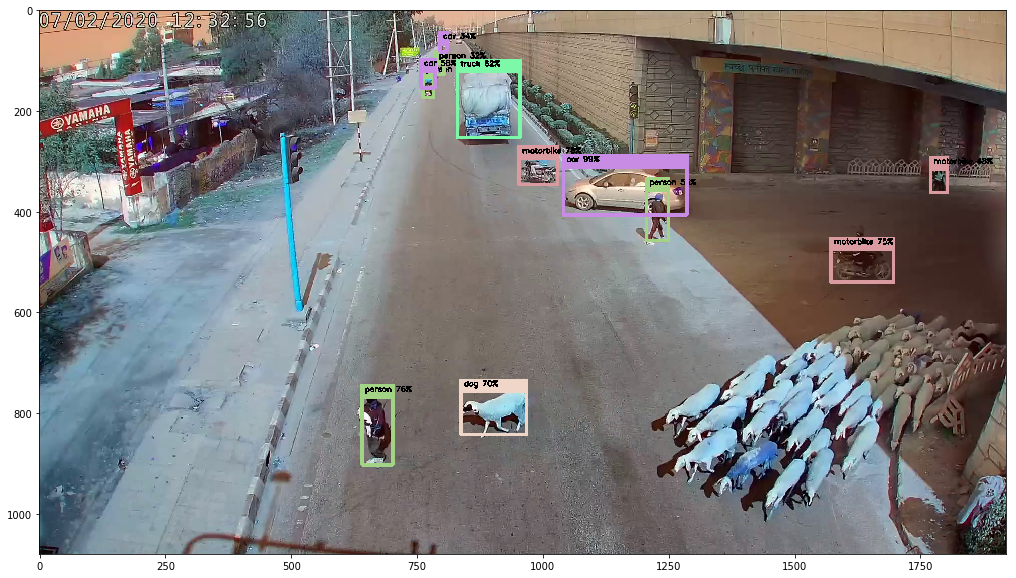

In [44]:
draw_boxes(img, detection_result, class_names)

In [ ]:
img= frames[680]
testimg= cv2.resize(img, _MODEL_SIZE)

testimg=testimg.reshape(1,416,416,3)

detection_result = sess.run(detections, feed_dict={inputs: testimg})

In [103]:
confidence = 0.5
cls_nums =[0,1,2,3]

for cls_num in cls_nums:
    try:
        cl = "./output/Class_"+str(cls_num)
        cl_base = cl+"/base/"
        cl_bb = cl+"/BBoxes/"
        os.mkdir(cl)
        os.mkdir(cl_base)
        os.mkdir(cl_bb)
    except:
        pass

del cls_num
i = 0
for frm_idx in frm_idxes:
    img = frames[frm_idx]
    testimg= cv2.resize(img, _MODEL_SIZE)

    testimg=testimg.reshape(1,416,416,3)

    detection_result = sess.run(detections, feed_dict={inputs: testimg})
    detection_result = detection_result[0]
    testimg = testimg.reshape(416,416,3)
    
    
    for cls_num in cls_nums:
        
        
        
        
        for box in detection_result[cls_num]:
            if box[-1] >= confidence:
                f_path = "./output/Class_"+str(cls_num)+"/BBoxes/"+str(i)+".txt"
                
                cord = [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
                file = open(f_path,"w") 
                file.write(str(cord)+"\n")
                file.close()
                print(f_path, "written successfully")
                
                
                image_name = "./output/Class_"+str(cls_num)+"/base/"+str(i)+".jpg"
                cv2.imwrite(image_name, testimg) 
                print(image_name, "written succesfully of shape", testimg.shape)
                i = i + 1           

./output/Class_0/BBoxes/0.txt written successfully
./output/Class_0/base/0.jpg written succesfully of shape (416, 416, 3)
./output/Class_2/BBoxes/1.txt written successfully
./output/Class_2/base/1.jpg written succesfully of shape (416, 416, 3)
./output/Class_2/BBoxes/2.txt written successfully
./output/Class_2/base/2.jpg written succesfully of shape (416, 416, 3)
./output/Class_2/BBoxes/3.txt written successfully
./output/Class_2/base/3.jpg written succesfully of shape (416, 416, 3)
./output/Class_0/BBoxes/4.txt written successfully
./output/Class_0/base/4.jpg written succesfully of shape (416, 416, 3)
./output/Class_0/BBoxes/5.txt written successfully
./output/Class_0/base/5.jpg written succesfully of shape (416, 416, 3)
./output/Class_0/BBoxes/6.txt written successfully
./output/Class_0/base/6.jpg written succesfully of shape (416, 416, 3)
./output/Class_2/BBoxes/7.txt written successfully
./output/Class_2/base/7.jpg written succesfully of shape (416, 416, 3)
./output/Class_2/BBoxes/

['132', ' 112', ' 138', ' 137']


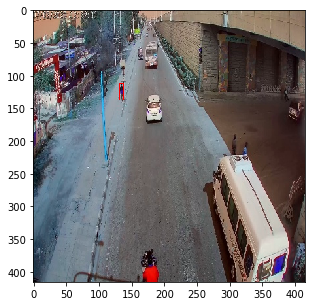

In [144]:
file_idx = 0

boxfile = open("./output/Class_0/BBoxes/"+str(file_idx)+".txt","r+")  
  

coordstr = boxfile.read()
boxfile.close()

cords = coordstr[1:-2].split(',')
print(cords)
base = cv2.imread("./output/Class_0/base/"+str(file_idx)+".jpg")

x1=int(cords[0])
y1=int(cords[1])
x2=int(cords[2])
y2=int(cords[3])

'''print(x1,y1,x2,y2)
print(cls)
print(color)'''


thickness= max(base.shape[0],base.shape[1])//300

## main rectangle
base=cv2.rectangle(base,(x1,y1),(x2,y2),(255,0,0),thickness=thickness)
plt.figure(figsize=(100,5))
plt.imshow(base)
plt.show()